In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
train = pd.read_csv('playground-series-s5e6/train.csv',index_col='id')
test = pd.read_csv('playground-series-s5e6/test.csv',index_col = 'id')
origin = pd.read_csv('playground-series-s5e6/Fertilizer Prediction.csv')

In [4]:
train = pd.concat([train,origin], axis= 0 )

In [5]:
train.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 850000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      850000 non-null  int64 
 1   Humidity         850000 non-null  int64 
 2   Moisture         850000 non-null  int64 
 3   Soil Type        850000 non-null  object
 4   Crop Type        850000 non-null  object
 5   Nitrogen         850000 non-null  int64 
 6   Potassium        850000 non-null  int64 
 7   Phosphorous      850000 non-null  int64 
 8   Fertilizer Name  850000 non-null  object
dtypes: int64(6), object(3)
memory usage: 64.8+ MB


In [7]:
train.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,850000.000000,850000.000000,850000.000000,850000.000000,850000.000000,850000.000000
mean,31.503534,61.032665,45.162887,23.081215,9.477581,21.066198
std,4.024909,6.648149,11.799929,11.219842,5.765965,12.352064
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


## Numeric Feature Ranges

- **Feature	Range	    Notes**
- Temparature	25–38°C	Reasonable
- Humidity	    50–72%	Moderate spread
- Moisture	    25–65	Looks usable
- Nitrogen	    4–42	Wide
- Potassium	    0–19	Some zeros
- Phosphorous	0–42	Wide

Potassium has some 0s, which might be edge cases or indicative of low-fertility soils.

In [8]:
print("Missing values in train:\n", train.isnull().sum())
print("Missing values in test:\n", test.isnull().sum())

Missing values in train:
 Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64
Missing values in test:
 Temparature    0
Humidity       0
Moisture       0
Soil Type      0
Crop Type      0
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64


## Data Quality
- No missing values in train or test — clean data.

- All features are properly typed (int or object).

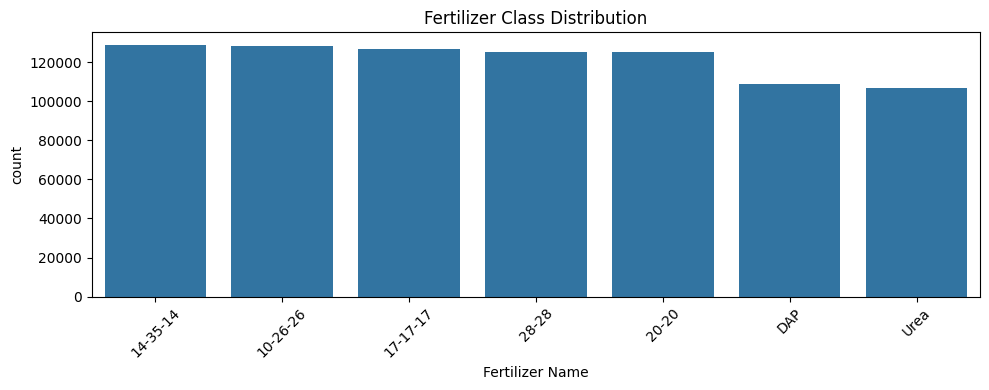

In [9]:
# 1. Class distribution of fertilizers
plt.figure(figsize=(10, 4))
sns.countplot(data=train, x="Fertilizer Name", order=train["Fertilizer Name"].value_counts().index)
plt.title("Fertilizer Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Fertilizer Class Distribution

Fairly balanced:
- 5 fertilizers (14-35-14, 10-26-26, 17-17-17, 28-28, 20-20): ~120,000 samples each.

- 2 fertilizers (DAP, Urea): ~100,000 each.

Good for classification — no oversampling/undersampling needed.

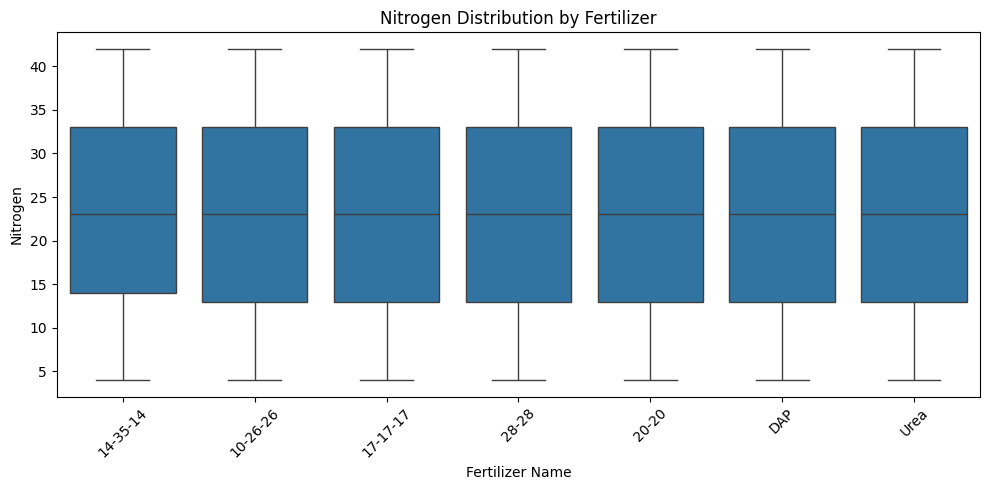

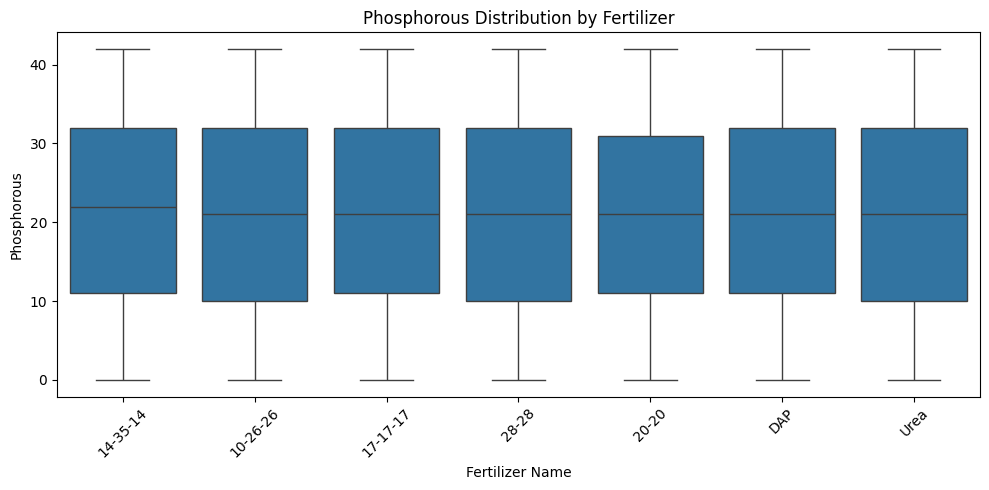

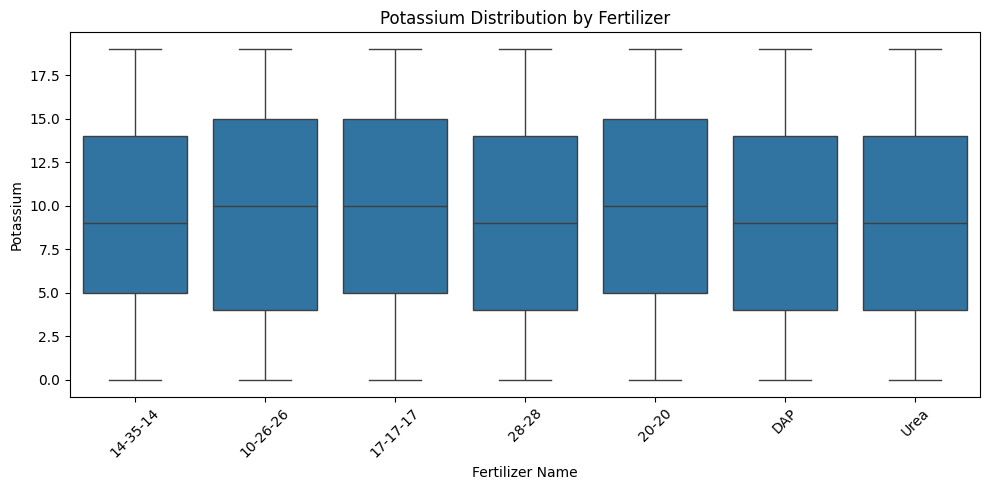

In [10]:
# 2. Boxplot: Nutrient levels per Fertilizer
for nutrient in ["Nitrogen", "Phosphorous", "Potassium"]:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=train, x="Fertilizer Name", y=nutrient, order=train["Fertilizer Name"].value_counts().index)
    plt.title(f"{nutrient} Distribution by Fertilizer")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Nutrient Distribution per Fertilizer
All nutrients have similar distributions across fertilizers, except potassium, which shows some variation.

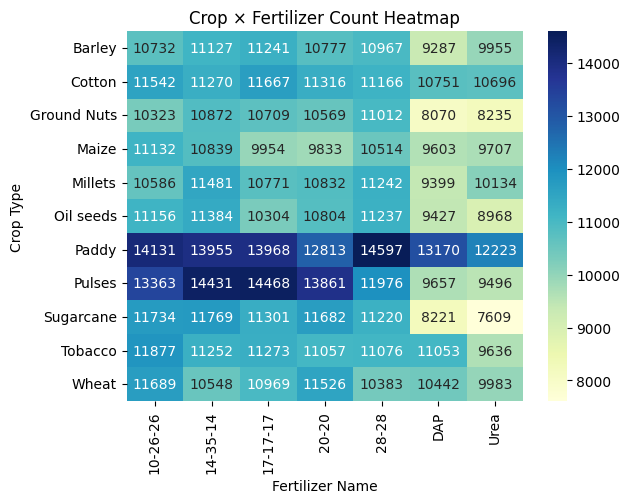

In [11]:
# 3. Crop vs Fertilizer heatmap
crop_fert_counts = pd.crosstab(train["Crop Type"], train["Fertilizer Name"])
sns.heatmap(crop_fert_counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Crop × Fertilizer Count Heatmap")
plt.show()

In [12]:
crop_fert_counts

Fertilizer Name,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
Crop Type,,,,,,,
Barley,10732,11127,11241,10777,10967,9287,9955
Cotton,11542,11270,11667,11316,11166,10751,10696
Ground Nuts,10323,10872,10709,10569,11012,8070,8235
Maize,11132,10839,9954,9833,10514,9603,9707
Millets,10586,11481,10771,10832,11242,9399,10134
Oil seeds,11156,11384,10304,10804,11237,9427,8968
Paddy,14131,13955,13968,12813,14597,13170,12223
Pulses,13363,14431,14468,13861,11976,9657,9496
Sugarcane,11734,11769,11301,11682,11220,8221,7609


## Crop Type × Fertilizer

- Almost all crops are spread across fertilizers.

- But some crops like Barley, Cotton, Ground Nuts may lean slightly toward specific fertilizers.

- No hard one-to-one mapping (which is good — we'll need a model).

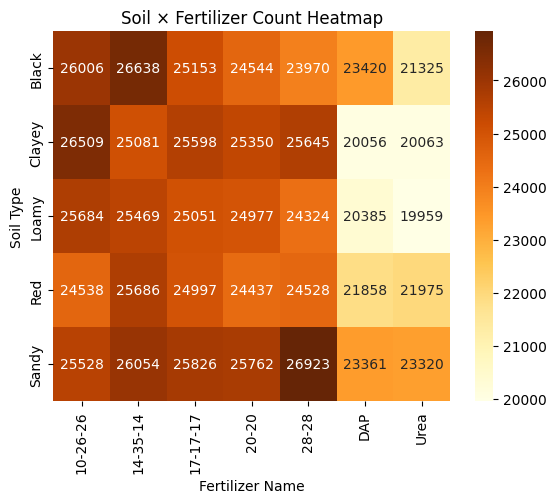

In [13]:
# 4. Soil vs Fertilizer heatmap
soil_fert_counts = pd.crosstab(train["Soil Type"], train["Fertilizer Name"])
sns.heatmap(soil_fert_counts, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Soil × Fertilizer Count Heatmap")
plt.show()

In [14]:
soil_fert_counts

Fertilizer Name,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
Soil Type,,,,,,,
Black,26006,26638,25153,24544,23970,23420,21325
Clayey,26509,25081,25598,25350,25645,20056,20063
Loamy,25684,25469,25051,24977,24324,20385,19959
Red,24538,25686,24997,24437,24528,21858,21975
Sandy,25528,26054,25826,25762,26923,23361,23320


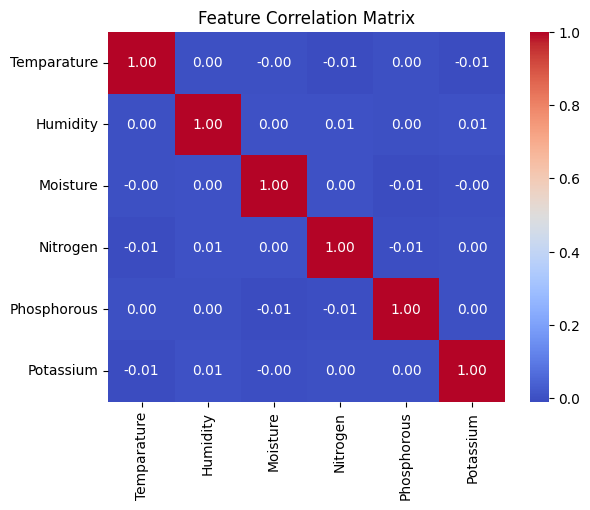

In [15]:
# 5. Correlation Matrix (Numerical Features Only)
numeric_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Phosphorous', 'Potassium']
corr_matrix = train[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [16]:
corr_matrix

,Temparature,Humidity,Moisture,Nitrogen,Phosphorous,Potassium
Temparature,1.000000,0.001560,-0.001574,-0.005865,0.000404,-0.009510
Humidity,0.001560,1.000000,0.003249,0.006062,0.002300,0.005091
Moisture,-0.001574,0.003249,1.000000,0.003035,-0.006570,-0.001659
Nitrogen,-0.005865,0.006062,0.003035,1.000000,-0.005337,0.000511
Phosphorous,0.000404,0.002300,-0.006570,-0.005337,1.000000,0.000185
Potassium,-0.009510,0.005091,-0.001659,0.000511,0.000185,1.000000


## What This Tells Us for Feature Engineering

1. Numerical features are usable directly after normalization.

2. Fertilizer is not uniquely determined by any single input — a model is necessary.

3. Soil type, crop type, and nutrient values will be key to making predictions.

4. Some possible features to add:

- Total_NPK = N + P + K

- N_to_K_ratio, P_to_K_ratio

- Encode Crop Type and Soil Type with embeddings or one-hot

- Flag if any nutrient is zero (e.g., is_potassium_zero)

- Possibly cluster crops or soils by nutrient profile

In [17]:
crop_nutrient_req_map = {
    'Sugarcane': (50, 32.5, 37.5),
    'Millets': (20, 10, 0),
    'Barley': (110, 0, 0),
    'Paddy': (0, 0, 0),  # unknowns = 0 or np.nan
    'Pulses': (0, 0, 0),
    'Tobacco': (0, 0, 0),
    'Ground Nuts': (12.5, 17.5, 11.25),
    'Maize': (0, 27.5, 110),
    'Cotton': (68.75, 30, 37.5),
    'Wheat': (140, 0, 0),
    'Oil Seeds': (67.5, 0, 0)
}

for i, nutrient in enumerate(['crop_N_req', 'crop_P_req', 'crop_K_req']):
    train[nutrient] = train['Crop Type'].map(lambda x: crop_nutrient_req_map.get(x, (0, 0, 0))[i])
    test[nutrient] = test['Crop Type'].map(lambda x: crop_nutrient_req_map.get(x, (0, 0, 0))[i])


In [18]:
soil_avg_npk_map = {
    'Sandy': (620, 14.2, 98),
    'Black': (88.5, 27, 199),
    'Clayey': (82.6, 20.75, 284.8),
    'Red': (72, 28, 123.5),
    'Loamy': (1500, 8.6, 104)
}

for i, nutrient in enumerate(['soil_N_avg', 'soil_P_avg', 'soil_K_avg']):
    train[nutrient] = train['Soil Type'].map(lambda x: soil_avg_npk_map[x][i])
    test[nutrient] = test['Soil Type'].map(lambda x: soil_avg_npk_map[x][i])


In [19]:
for nutrient in ['N', 'P', 'K']:
    train[f'{nutrient}_gap'] = train[f'crop_{nutrient}_req'] - train[f'soil_{nutrient}_avg']
    test[f'{nutrient}_gap'] = test[f'crop_{nutrient}_req'] - test[f'soil_{nutrient}_avg']


In [20]:
nutrient_key_map = {
    'Nitrogen': 'N',
    'Phosphorous': 'P',
    'Potassium': 'K'
}

for nutrient, key in nutrient_key_map.items():
    train[f'{key}_abnormality'] = train[nutrient] - train[f'soil_{key}_avg']
    test[f'{key}_abnormality'] = test[nutrient] - test[f'soil_{key}_avg']


In [21]:
train['Crop_Soil'] = train['Crop Type'] + "_" + train['Soil Type']
test['Crop_Soil'] = test['Crop Type'] + "_" + test['Soil Type']

train['NPK_gap_product'] = train['N_gap'] * train['P_gap'] * train['K_gap']
test['NPK_gap_product'] = test['N_gap'] * test['P_gap'] * test['K_gap']

train['Moisture_Temp'] = train['Moisture'] * train['Temparature']
test['Moisture_Temp'] = test['Moisture'] * test['Temparature']

In [22]:
train['stress'] = abs(train['Humidity'] - 60) + abs(train['Moisture'] - 45)
test['stress'] = abs(test['Humidity'] - 60) + abs(test['Moisture'] - 45)


In [23]:
train.head().T

,0,1,2,3,4
Temparature,37,27,29,35,35
Humidity,70,69,63,62,58
Moisture,36,65,32,54,43
Soil Type,Clayey,Sandy,Sandy,Sandy,Red
Crop Type,Sugarcane,Millets,Millets,Barley,Paddy
Nitrogen,36,30,24,39,37
Potassium,4,6,12,12,2
Phosphorous,5,18,16,4,16
Fertilizer Name,28-28,28-28,17-17-17,10-26-26,DAP
crop_N_req,50.0,20.0,20.0,110.0,0.0


In [24]:
test.head().T

id,750000,750001,750002,750003,750004
Temparature,31,27,28,37,31
Humidity,70,62,72,53,55
Moisture,52,45,28,57,32
Soil Type,Sandy,Red,Clayey,Black,Red
Crop Type,Wheat,Sugarcane,Ground Nuts,Ground Nuts,Pulses
Nitrogen,34,30,14,18,13
Potassium,11,14,15,17,19
Phosphorous,24,15,4,36,14
crop_N_req,140.0,50.0,12.5,12.5,0.0
crop_P_req,0.0,32.5,17.5,17.5,0.0


In [25]:
train.shape

(850000, 25)

In [26]:
test.shape

(250000, 24)

In [27]:
train.to_csv('new_train.csv', index=False)
test.to_csv('new_test.csv', index=False)